In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
df = pd.read_csv('fifa_players.csv')

In [137]:
df['id'] = df.index
df.set_index('id', inplace=True)

In [138]:
df.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
id,,,,,,,,,,,,,,,,,,,,,
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


In [139]:
df.drop(['name', 'full_name', 'birth_date'], axis=1, inplace=True)

In [140]:
# df.info()

In [141]:
df.columns

Index(['age', 'height_cm', 'weight_kgs', 'positions', 'nationality',
       'overall_rating', 'potential', 'value_euro', 'wage_euro',
       'preferred_foot', 'international_reputation(1-5)', 'weak_foot(1-5)',
       'skill_moves(1-5)', 'body_type', 'release_clause_euro', 'national_team',
       'national_rating', 'national_team_position', 'national_jersey_number',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')

# Histogram

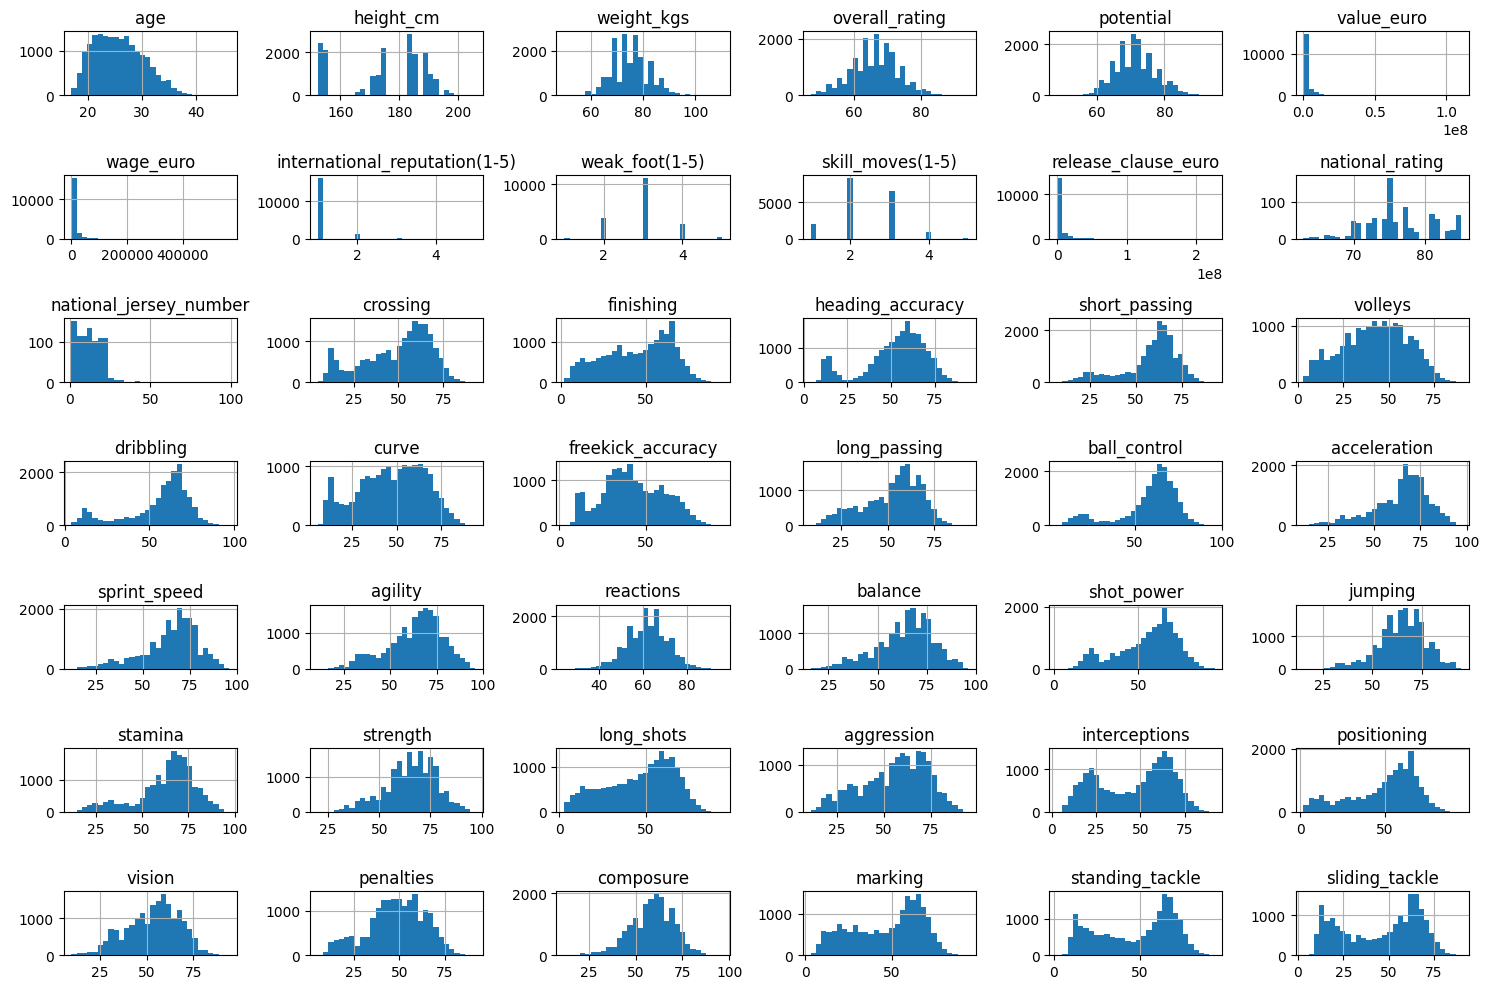

In [142]:
df.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

In [143]:
# number_cols = df.select_dtypes(include=['number']).columns.tolist()

# for col in number_cols:
#     plt.figure(figsize=(5, 2))
#     sns.histplot(df[col], kde=True)
#     plt.title(f'Histogram of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.show()

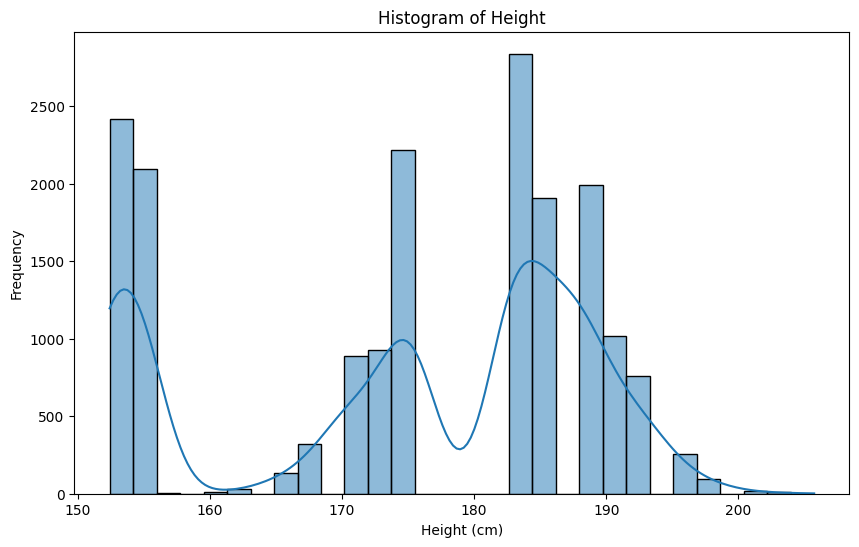

In [144]:
plt.figure(figsize=(10, 6))
sns.histplot(df['height_cm'], bins=30, kde=True)
plt.title('Histogram of Height')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.show()

In [145]:
df['height_cm'].describe()

count    17954.000000
mean       174.946921
std         14.029449
min        152.400000
25%        154.940000
50%        175.260000
75%        185.420000
max        205.740000
Name: height_cm, dtype: float64

In [146]:
#### Outliers

# Calculate the mean height for each position
mean_height_by_position = df[df['height_cm'] >= 160].groupby('positions')['height_cm'].mean()
mean_height_by_position
# # Function to replace height with mean height of positions
# def replace_height(row):
#     if row['height_cm'] < 160:
#         positions = row['positions'].split(',')
#         heights = [mean_height_by_position[pos] for pos in positions if pos in mean_height_by_position]
#         if heights:
#             return np.mean(heights)
#     return row['height_cm']

# # Apply the function to the dataframe
# df['height_cm'] = df.apply(replace_height, axis=1)

positions
CAM              174.869231
CAM,CDM          176.953333
CAM,CDM,CM       181.186667
CAM,CDM,CM,RM    175.260000
CAM,CDM,RM,CM    175.260000
                    ...    
ST,RW,LW         180.594000
ST,RW,LW,CAM     167.640000
ST,RW,LW,CF      182.880000
ST,RW,RM         185.420000
ST,RWB,RM        185.420000
Name: height_cm, Length: 738, dtype: float64

In [147]:
df['international_reputation(1-5)'].value_counts()

international_reputation(1-5)
1    16370
2     1226
3      301
4       51
5        6
Name: count, dtype: int64

# Handle missing values

In [148]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

value_euro                  255
wage_euro                   246
release_clause_euro        1837
national_team             17097
national_rating           17097
national_team_position    17097
national_jersey_number    17097
dtype: int64


In [149]:
missing_cols = missing_values.index.tolist()
missing_cols

['value_euro',
 'wage_euro',
 'release_clause_euro',
 'national_team',
 'national_rating',
 'national_team_position',
 'national_jersey_number']

In [150]:
df.drop(['national_team', 'national_rating', 'national_team_position',
         'national_jersey_number'], axis=1, inplace=True)

In [151]:
# df.head()

In [152]:
missing_cols = df.columns[df.isnull().any()].tolist()
for col in missing_cols:
    print(f'{col} HAS {df[col].isnull().sum()} missing values')


value_euro HAS 255 missing values
wage_euro HAS 246 missing values
release_clause_euro HAS 1837 missing values


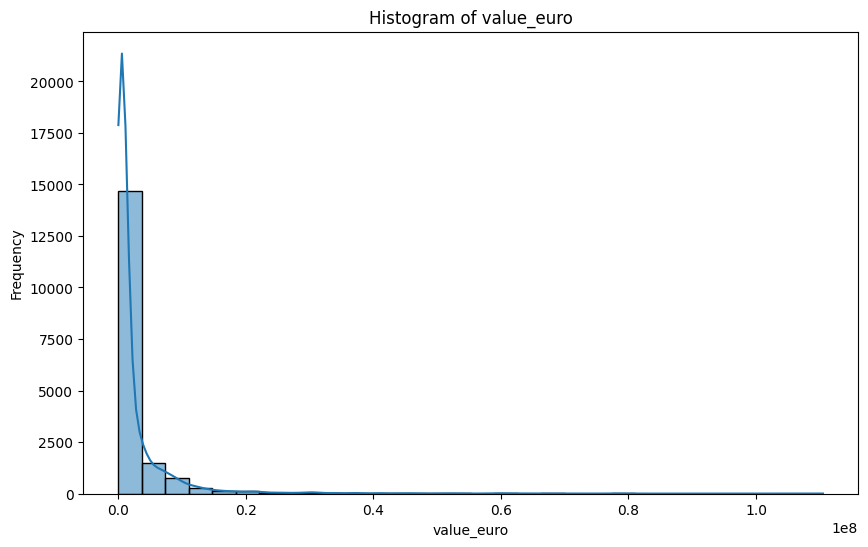

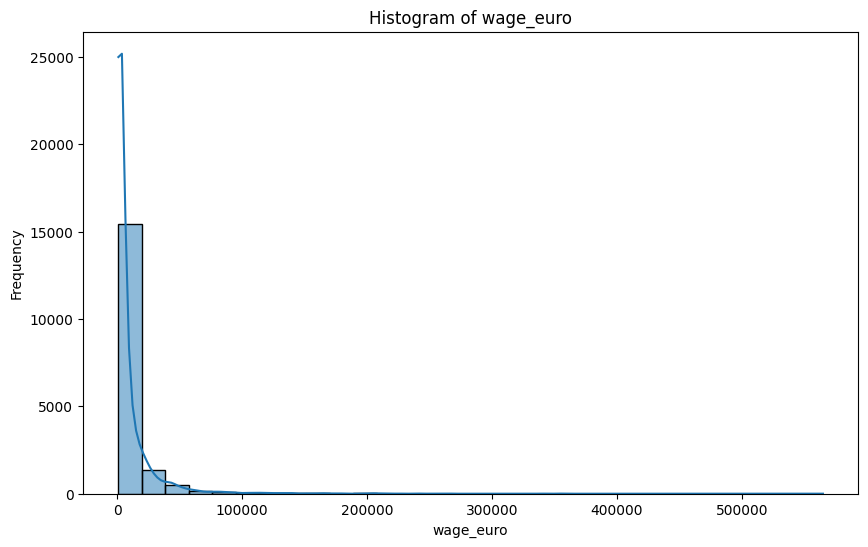

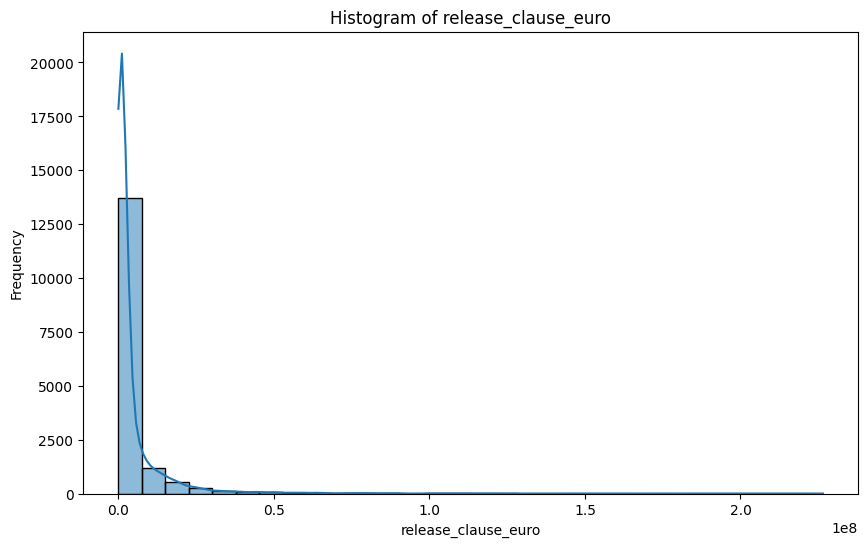

In [153]:
for col in missing_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

### Use MEAN to replace missing values

In [154]:
for col in missing_cols:
    df[col].fillna(df[col].mean(), inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_26788\134555192.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


### Use MEDIAN to replace missing values 

In [155]:

# for col in missing_cols:
#     df[col].fillna(df[col].median(), inplace=True)    

In [156]:
len(df.columns[df.isnull().any()].tolist())

0

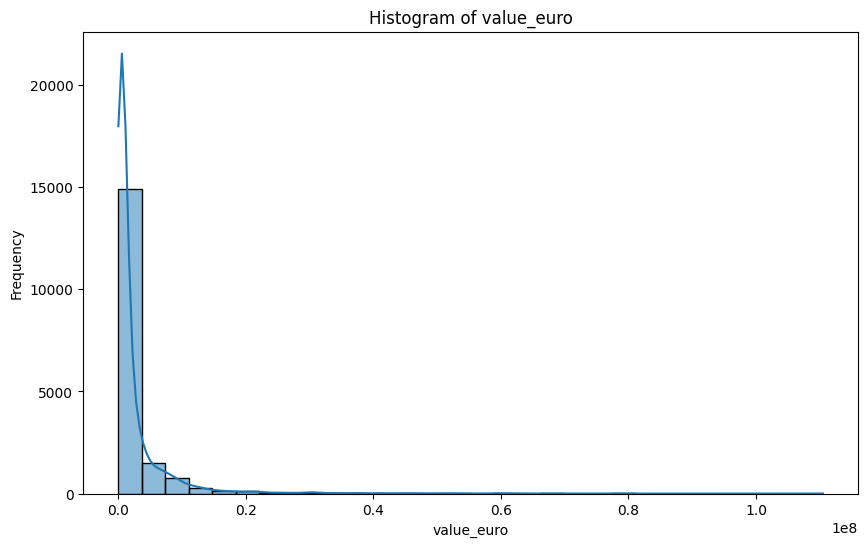

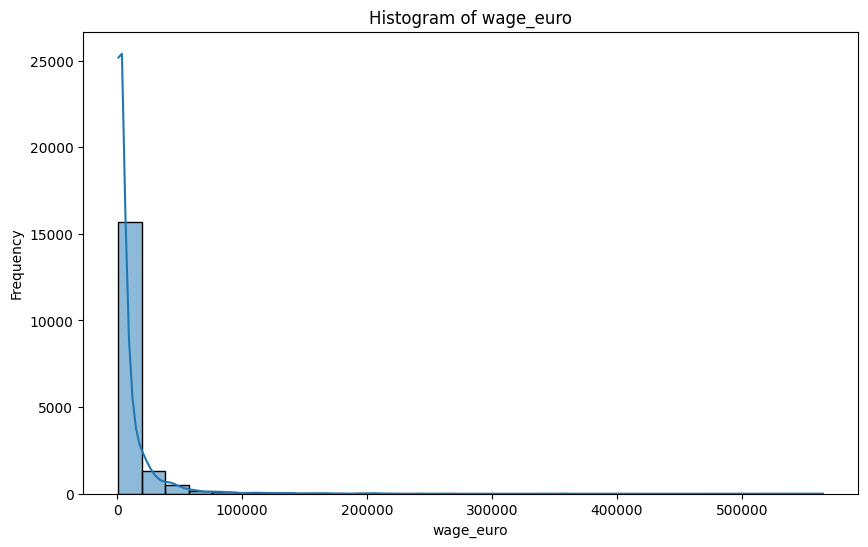

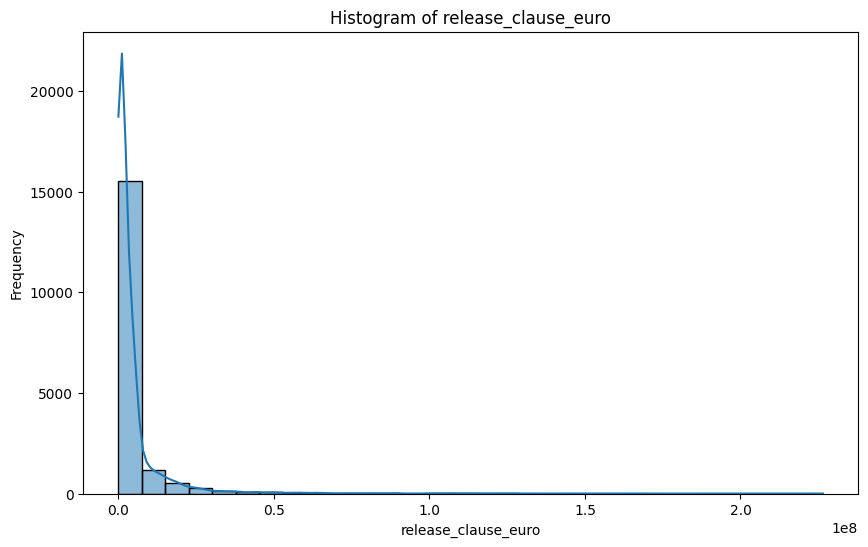

In [157]:
for col in missing_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Handle 'String' attributes

In [158]:
object_cols = df.select_dtypes(include='object').columns

object_cols

Index(['positions', 'nationality', 'preferred_foot', 'body_type'], dtype='object')

## preferred_foot

In [159]:
df['preferred_foot'].value_counts() # -> co the chuyen ve 0, 1

preferred_foot
Right    13781
Left      4173
Name: count, dtype: int64

## body_type

In [160]:
df['body_type'].value_counts()

body_type
Normal                 10393
Lean                    6468
Stocky                  1086
Messi                      1
Courtois                   1
PLAYER_BODY_TYPE_25        1
Akinfenwa                  1
Shaqiri                    1
Neymar                     1
C. Ronaldo                 1
Name: count, dtype: int64

In [161]:
df.head()

,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,value_euro,wage_euro,preferred_foot,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
id,,,,,,,,,,,,,,,,,,,,,
0,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,110500000.0,565000.0,Left,...,94,48,22,94,94,75,96,33,28,26
1,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,69500000.0,205000.0,Right,...,89,46,56,84,91,67,88,59,57,22
2,25,190.50,83.9,"CM,CAM",France,88,91,73000000.0,255000.0,Right,...,82,78,64,82,88,82,87,63,67,67
3,27,162.56,59.0,"LW,ST",Italy,88,88,62000000.0,165000.0,Right,...,84,34,26,83,87,61,83,51,24,22
4,27,187.96,88.9,CB,Senegal,88,91,60000000.0,135000.0,Right,...,15,87,88,24,49,33,80,91,88,87


In [162]:
valid_body_types = ['Normal', 'Lean', 'Stocky']
df = df[df['body_type'].isin(valid_body_types)]

In [163]:
df['body_type'].value_counts()

body_type
Normal    10393
Lean       6468
Stocky     1086
Name: count, dtype: int64

## nationality

In [164]:
df['nationality'].unique().shape

(160,)

In [165]:
# Identify countries with 5 or fewer players
countries_with_few_players = df['nationality'].value_counts()
countries_with_few_players = countries_with_few_players[countries_with_few_players <= 10].index
# len(countries_with_few_players)
# Replace these countries with 'Others'
df['nationality'] = df['nationality'].apply(lambda x: 'Others' if x in countries_with_few_players else x)

# Verify the changes
print(df['nationality'].value_counts())

nationality
England      1657
Germany      1199
Spain        1070
France        925
Argentina     903
             ... 
Angola         13
Zimbabwe       13
Benin          12
Togo           11
Estonia        11
Name: count, Length: 89, dtype: int64


In [166]:
# df['nationality'].value_counts()

## positions

In [167]:
df['positions'].value_counts()

positions
CB               2243
GK               2064
ST               1746
CM                764
CDM,CM            709
                 ... 
CF,CAM,CM           1
CAM,CM,RW,LW        1
CF,LM,RM            1
RB,RWB,RM,LWB       1
CAM,LM,RM,CF        1
Name: count, Length: 889, dtype: int64

In [168]:
df['positions'] = df['positions'].str.split(',')
df['positions']

id
1        [CAM, RM, CM]
2            [CM, CAM]
3             [LW, ST]
4                 [CB]
5                 [CB]
             ...      
17949    [RM, CAM, CM]
17950             [LB]
17951             [GK]
17952         [ST, LM]
17953             [ST]
Name: positions, Length: 17947, dtype: object

In [169]:
df.shape

(17947, 44)

In [170]:
df_exploded = df.explode('positions')
df_encoded = pd.get_dummies(df_exploded, columns=['positions'])

one_hot_columns = [col for col in df_encoded.columns if col.startswith('positions_')]
df_one_hot_sum = df_encoded[one_hot_columns].groupby('id').sum()
df_final = df.drop(columns=['positions']).join(df_one_hot_sum)

df = df_final

In [171]:
df.head()

,age,height_cm,weight_kgs,nationality,overall_rating,potential,value_euro,wage_euro,preferred_foot,international_reputation(1-5),...,positions_GK,positions_LB,positions_LM,positions_LW,positions_LWB,positions_RB,positions_RM,positions_RW,positions_RWB,positions_ST
id,,,,,,,,,,,,,,,,,,,,,
1,27,154.94,76.2,Denmark,88,89,69500000.0,205000.0,Right,3,...,0,0,0,0,0,0,1,0,0,0
2,25,190.50,83.9,France,88,91,73000000.0,255000.0,Right,4,...,0,0,0,0,0,0,0,0,0,0
3,27,162.56,59.0,Italy,88,88,62000000.0,165000.0,Right,3,...,0,0,0,1,0,0,0,0,0,1
4,27,187.96,88.9,Senegal,88,91,60000000.0,135000.0,Right,3,...,0,0,0,0,0,0,0,0,0,0
5,27,193.04,92.1,Netherlands,88,90,59500000.0,215000.0,Right,3,...,0,0,0,0,0,0,0,0,0,0


# Handle outliers in 'height_cm'

<Axes: >

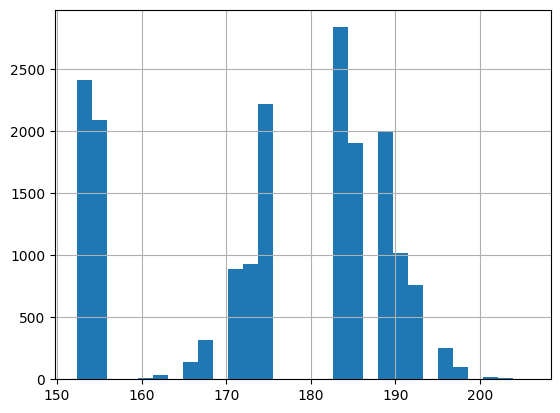

In [172]:
df['height_cm'].hist(bins=30)

In [173]:
# Tạo một cột mới 'height_cm_adjusted' là bản sao của 'height_cm' để giữ giá trị thay thế
df['height_cm_adjusted'] = df['height_cm']

# Lấy danh sách các cột vị trí
position_columns = [col for col in df.columns if col.startswith('positions_')]

# Lặp qua từng cầu thủ
for index, row in df.iterrows():
    # Nếu chiều cao của cầu thủ < 160 cm, thực hiện thay thế
    if row['height_cm'] < 160:
        # Tìm các vị trí mà cầu thủ có thể chơi (giá trị cột là 1)
        positions_played = [col for col in position_columns if row[col] == 1]
        
        # Nếu cầu thủ chơi ở ít nhất một vị trí, tính median của chiều cao ở các vị trí đó
        if positions_played:
            median_heights = []
            for position in positions_played:
                # Lấy median của chiều cao cho vị trí này (chỉ lấy các cầu thủ có chiều cao >= 160 cm)
                median_height = df.loc[(df[position] == 1) & (df['height_cm'] >= 160), 'height_cm'].median()
                if not np.isnan(median_height):  # Kiểm tra nếu median_height không phải là NaN
                    median_heights.append(median_height)
            
            # Tính trung bình của các median chiều cao từ các vị trí
            if median_heights:
                replacement_height = np.mean(median_heights)  # Hoặc np.median(median_heights)
                df.at[index, 'height_cm_adjusted'] = replacement_height

# Xem lại kết quả
print(df[['height_cm', 'height_cm_adjusted']].head(10))


    height_cm  height_cm_adjusted
id                               
1      154.94              175.26
2      190.50              190.50
3      162.56              162.56
4      187.96              187.96
5      193.04              193.04
6      152.40              177.80
7      172.72              172.72
8      193.04              193.04
9      185.42              185.42
10     187.96              187.96


<Axes: >

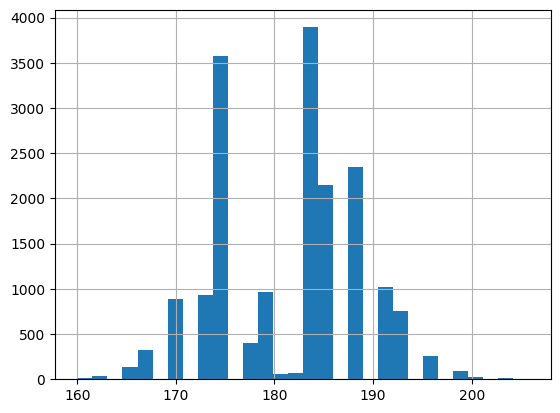

In [174]:
df['height_cm_adjusted'].hist(bins=30)

In [175]:
df.drop(columns=['height_cm'], inplace=True)
df.rename(columns={'height_cm_adjusted': 'height_cm'}, inplace=True)

<Axes: >

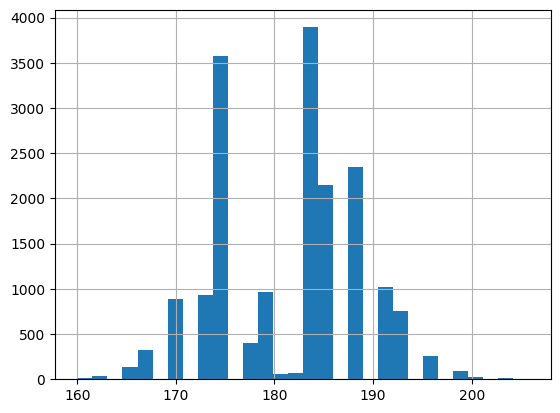

In [176]:
df['height_cm'].hist(bins=30)

# Handle duplicated values

In [177]:
df.duplicated().sum()

np.int64(0)

# Label Encoder

In [178]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

object_cols = df.select_dtypes(include='object').columns

for col in object_cols:
    df[col] = le.fit_transform(df[col])

In [179]:
for col in object_cols:
    print(f'{col} -> {df[col].unique()}')

nationality -> [25 32 47 72 57  3 36 85 77 74 10 21  6 20 18 56 66 78  9 54 28  5 43 42
 87 83 62 73 48 13 63  4  1 68 69 46 79 16 81 82 59 64 61 38 84 86 45 27
 15 71 17 52 55 14 53 37 39 65 60 50 58 76 67 26 12 23 75 33 30 22 24 41
 40 70 51 35  2 88 19  0  8 34 49  7 31 80 11 29 44]
preferred_foot -> [1 0]
body_type -> [0 1 2]


# Outliers

In [180]:
# # Select numerical columns
# numerical_cols = df.select_dtypes(include=['number']).columns

# # Plot boxplot for each numerical column
# for col in numerical_cols:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x=df[col])
#     plt.title(f'Boxplot of {col}')
#     plt.xlabel(col)
#     plt.show()

In [181]:
df['wage_euro'].head(100)

id
1      205000.0
2      255000.0
3      165000.0
4      135000.0
5      215000.0
         ...   
98      57000.0
99      35000.0
100    105000.0
101     54000.0
102     36000.0
Name: wage_euro, Length: 100, dtype: float64

<Axes: xlabel='wage_euro'>

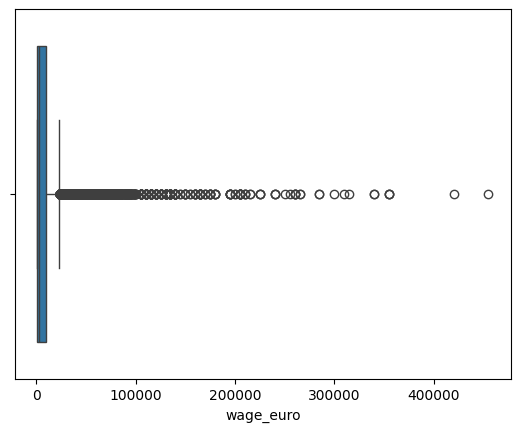

In [182]:
sns.boxplot(x=df['wage_euro'])

<Axes: >

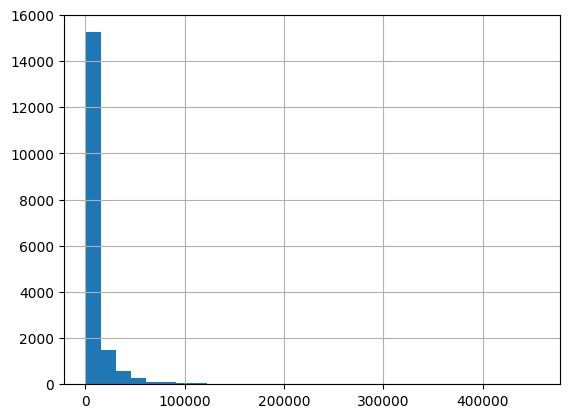

In [183]:
df['wage_euro'].hist(bins=30)

In [184]:
# df[df['value_euro'] > 100000000]['value_euro']

<Axes: >

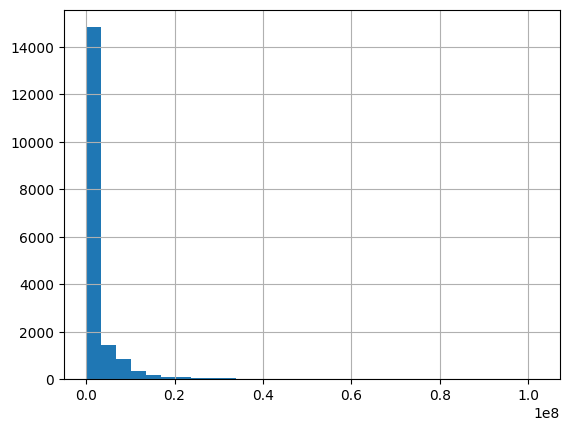

In [185]:
df['value_euro'].hist(bins=30)

# Export new train.csv

In [186]:
df.to_csv('mean_data.csv', index=False)